### Figure 2 : Ripple oscillations

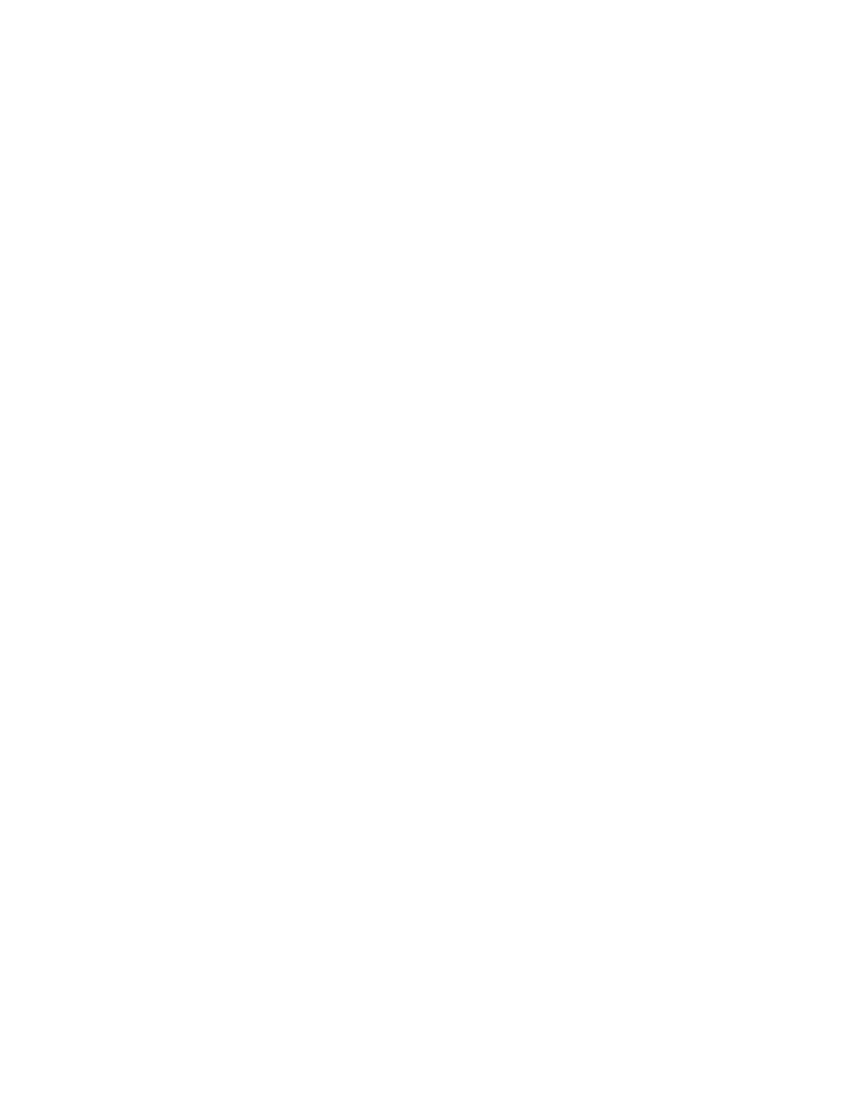

In [8]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import subjects
from subjects import sd_span, nsd_span, grp_span
import pandas as pd
import seaborn as sns
from neuropy.plotting import Fig
from scipy import stats
from statannotations.Annotator import Annotator


grpdata = subjects.GroupData()
group = ['NSD','SD']

# ripple
psd = grpdata.ripple_psd
examples = grpdata.ripple_examples
power= grpdata.ripple_zscore

ripple_autocorr = grpdata.ripple_autocorr

rate = grpdata.ripple_rate
colors_ripple_rate = subjects.colors_sd(1.3)

total_dur = grpdata.ripple_total_duration
colors_rpl_dur = subjects.colors_sd(1.2)

peak_freq = grpdata.ripple_peak_frequency
colors_pf = subjects.colors_sd(1.3)

# pbe

pbe_rate = grpdata.pbe_rate
pbe_total_dur = grpdata.pbe_total_duration

# frate
frate_in_rpl = grpdata.frate_in_ripple
colors_frate = [
    [subjects.nsd.color(0.9), subjects.nsd.color(1.9)],
    [subjects.sd.color(1), subjects.sd.color(1.5)],
]


fig = Fig(grid=(5, 4), hspace=0.5, wspace=0.5)
filename = subjects.figpath_sd / "figure2"
caption = "Ripple and PBEs compared between SD and NSD sessions.\n(A) Mean ripple power spectral density across SD and NSD sessions during Pre, Maze and POST. Error bars indicate +/- SEM.\n(B) Distribution of peak ripple frequency calculated using wavelet compared across SD (orange) and NSD (purple) at selected epochs of each session. \n(C) Rate of ripple occurence during POST of SD (top left) and NSD (top right) sessions. Black dashed line represent median across sessions. Bottom panel shows integrated ripple duration during POST. \n(D) Same as (C) but of PBE events. \nE) Normalized z-scored firing rate within ripples calculated at various epochs for pyramidal and interneurons. Error bars indicate 90% CI."


### Power spectrum
- will be moved to supplementary 

### example ripples

### Peak frequency

In [9]:
ax = plt.subplot(fig.gs[0, :2])
v = sns.lineplot(
    data=peak_freq,
    x="t",
    y="f",
    hue="grp",
    hue_order=group,
    palette=colors_pf,
    legend=None,
    marker="o",
    err_style='bars',
    # scale=0.5,
    # capsize=0,
    # split=True,
    # inner="quartile",
    linewidth=1,
    ci=99,
    # scale="width",
    # saturation=1,
    ax=ax,
)
ax.set_ylim(bottom=155)
ax.tick_params("x", labelrotation=30)
# sd_span(ax, s=2, w=4)
grp_span(ax,s=2,w=4)
ax.legend([], frameon=False)
ax.set_ylabel("Intraripple frequency (Hz)")
ax.set_xlabel("")
# ax.axvspan(2, 6, color="#dbf9ae", zorder=-1)
# ax.set_title("Peak ripple frequency", loc="left")
fig.legend(ax, group, colors_pf, x=0.80, y=0.94)
# ax.grid(True)

axin = ax.inset_axes([2, 163, 4, 25], transform=ax.transData,zorder=-1)
# axin = plt.subplot(fig.gs[0, 2:])
sns.lineplot(
    data=ripple_autocorr,
    x="lag_time",
    y="auto_corr",
    ci=None,
    hue="grp",
    hue_order=group,
    palette=colors_pf,
    lw=1,
    ax=axin,
    alpha=0.7,
)
axin.legend([], frameon=False)
# fig.legend(axin, group, colors_pf, x=0.82, y=0.94)
# axin.set_xlim(-18, 18)
axin.set_ylim(-0.7, 1)
# axin.set_facecolor("#dbf9ae")
# axin.set_yticks([])
# axin.set_yticks([])
fig.remove_spines(axin, ["left"])
axin.set_xlabel("Lag time (ms)")
axin.set_ylabel("")
# axin.set_title("Ripple autocorrelation")
axin.axis("off")
# fig.panel_label(ax, "A")

# --- stat annotations ---------
pairs = [
    (("pre", "NSD"), ("pre", "SD")),
    (("maze", "NSD"), ("maze", "SD")),
    # (("0-1", "NSD"), ("0-1", "SD")),
    # (("1-2", "NSD"), ("1-2", "SD")),
    (("2-3", "NSD"), ("2-3", "SD")),
    # (("3-4", "NSD"), ("3-4", "SD")),
    # (("4-5", "NSD"), ("4-5", "SD")),
    (("5-6", "NSD"), ("5-6", "SD")),
    # (("6-7", "NSD"), ("6-7", "SD")),
    (("7-8", "NSD"), ("7-8", "SD")),
]

annotator = Annotator(
    ax,
    pairs,
    data=peak_freq,
    x="t",
    y="f",
    order=[
        "pre",
        "maze",
        "0-1",
        "1-2",
        "2-3",
        "3-4",
        "4-5",
        "5-6",
        "6-7",
        "7-8",
    ],
    hue="grp",
    hue_order=group,
)
annotator.configure(
    test="Mann-Whitney-ls", text_format="star", loc="outside", verbose=False
)
annotator.apply_and_annotate()



# ----- other stats ------

# increase from PRE to MAZE
peak_freq_pre = peak_freq[peak_freq["t"] == "pre"]["f"].values
peak_freq_maze = peak_freq[peak_freq["t"] == "maze"]["f"].values
mean_freq_pre = np.mean(peak_freq_pre)
mean_freq_maze = np.mean(peak_freq_maze)
delta_pre_to_maze = mean_freq_maze - mean_freq_pre
stats_pre_to_maze = stats.ttest_ind(peak_freq_pre, peak_freq_maze)
print(f"Change intraripple frequency pre to maze:{delta_pre_to_maze}")
print(f"Stats intraripple frequency pre to maze:{stats_pre_to_maze}")

# Change from MAZE to POST
sd_rows = (peak_freq["t"].isin(["1-2", "Zt3", "Zt5"])) & (peak_freq["grp"] == "SD")
nsd_rows = (peak_freq["t"].isin(["Zt1", "Zt3", "Zt5"])) & (peak_freq["grp"] == "NSD")
peak_freq_maze_sd = peak_freq[(peak_freq["t"] == "maze") & (peak_freq["grp"] == "SD")][
    "f"
].values
peak_freq_maze_nsd = peak_freq[
    (peak_freq["t"] == "maze") & (peak_freq["grp"] == "NSD")
]["f"].values
peak_freq_zt5_sd = peak_freq[sd_rows]["f"].values
peak_freq_zt5_nsd = peak_freq[nsd_rows]["f"].values

mean_freq_maze_sd = np.mean(peak_freq_maze_sd)
mean_freq_zt5_sd = np.mean(peak_freq_zt5_sd)
mean_freq_maze_nsd = np.mean(peak_freq_maze_nsd)
mean_freq_zt5_nsd = np.mean(peak_freq_zt5_nsd)

delta_maze_to_zt5_sd = mean_freq_maze_sd - mean_freq_zt5_sd
delta_maze_to_zt5_nsd = mean_freq_maze_nsd - mean_freq_zt5_nsd
delta_sd_to_nsd_zt5 = mean_freq_zt5_sd - mean_freq_zt5_nsd

stats_maze_to_zt5_sd = stats.ttest_ind(peak_freq_maze_sd, peak_freq_zt5_sd)
stats_maze_to_zt5_nsd = stats.ttest_ind(peak_freq_maze_nsd, peak_freq_zt5_nsd)
stats_sd_to_nsd_zt5 = stats.ttest_ind(peak_freq_zt5_nsd, peak_freq_zt5_sd)
print(f"Change intraripple frequency maze to sd:{delta_maze_to_zt5_sd}")
print(f"Stats intraripple frequency maze to sd:{stats_maze_to_zt5_sd}")

print(f"Change intraripple frequency maze to nsd:{delta_maze_to_zt5_nsd}")
print(f"Stats intraripple frequency maze to nsd:{stats_maze_to_zt5_nsd}")

print(f"Change intraripple frequency sd to nsd:{delta_sd_to_nsd_zt5}")
print(f"Stats intraripple frequency sd to nsd:{stats_sd_to_nsd_zt5}")


Change intraripple frequency pre to maze:8.767386838992877
Stats intraripple frequency pre to maze:Ttest_indResult(statistic=-18.895564288429938, pvalue=3.4397278088875714e-79)
Change intraripple frequency maze to sd:3.894041374963365
Stats intraripple frequency maze to sd:Ttest_indResult(statistic=6.4487593562490435, pvalue=1.1807259564441634e-10)
Change intraripple frequency maze to nsd:nan
Stats intraripple frequency maze to nsd:Ttest_indResult(statistic=nan, pvalue=nan)
Change intraripple frequency sd to nsd:nan
Stats intraripple frequency sd to nsd:Ttest_indResult(statistic=nan, pvalue=nan)


/home/bapung/miniconda3/envs/data_analysis/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/bapung/miniconda3/envs/data_analysis/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Ripple zscore

In [15]:
ax = plt.subplot(fig.gs[0, 2:])
v = sns.lineplot(
    data=power,
    x="t",
    y="zscore",
    hue="grp",
    hue_order=group,
    palette=colors_pf,
    legend=None,
    marker="o",
    err_style='bars',
    # scale=0.5,
    # capsize=0,
    # split=True,
    # inner="quartile",
    linewidth=1,
    ci=99,
    # scale="width",
    # saturation=1,
    ax=ax,
)
ax.tick_params("x", labelrotation=30)
# sd_span(ax, s=2, w=4)
grp_span(ax,s=0,w=4)
ax.legend([], frameon=False)
ax.set_ylabel("Ripple zscores")
ax.set_xlabel("Zt time (h)")

pairs = [
    (("0-1", "NSD"), ("0-1", "SD")),
    # (("1-2", "NSD"), ("1-2", "SD")),
    (("2-3", "NSD"), ("2-3", "SD")),
    # (("3-4", "NSD"), ("3-4", "SD")),
    (("4-5", "NSD"), ("4-5", "SD")),
    # (("5-6", "NSD"), ("5-6", "SD")),
    (("6-7", "NSD"), ("6-7", "SD")),
    # (("7-8", "NSD"), ("7-8", "SD")),
]

annotator = Annotator(
    ax,
    pairs,
    data=peak_freq,
    x="t",
    y="f",
    order=[
        "0-1",
        "1-2",
        "2-3",
        "3-4",
        "4-5",
        "5-6",
        "6-7",
        "7-8",
    ],
    hue="grp",
    hue_order=group,
)
annotator.configure(
    test="t-test_ind", text_format="star", loc="outside", verbose=True
)
annotator.apply_and_annotate()




p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0-1_NSD vs. 0-1_SD: t-test independent samples, P_val:9.510e-39 t=-1.306e+01
2-3_NSD vs. 2-3_SD: t-test independent samples, P_val:3.542e-277 t=-3.621e+01
4-5_NSD vs. 4-5_SD: t-test independent samples, P_val:0.000e+00 t=-4.316e+01
6-7_NSD vs. 6-7_SD: t-test independent samples, P_val:8.382e-06 t=-4.457e+00


(<AxesSubplot:xlabel='Zt time (h)', ylabel='Ripple zscores'>,
  <statannotations.Annotation.Annotation at 0x7f4f824f73d0>])

### Ripple rate

### Integrated ripple duration

In [11]:
ax = plt.subplot(fig.gs[1, :2])
# sns.boxplot(data=total_dur,x='Zt',y='rpl_duration',hue='grp',**subjects.boxplot_kw())
for i, grp in enumerate(["NSD", "SD"]):
    df = total_dur[total_dur["grp"] == grp]
    mean = df.groupby("Zt").mean()
    sem = df.groupby("Zt").sem(0).rpl_duration
    if i == 0:
        delta_x = -0.1
    else:
        delta_x = 0.1
    # sns.scatterplot(data=df,x='Zt',y='rpl_duration',ax=ax)
    # ax.scatter(
    #     df["Zt"].values.astype("int") - 1 + delta_x,
    #     df["rpl_duration"],
    #     c=colors_rpl_dur[i],
    #     s=6,
    #     alpha=0.3,
    # )

    ax.errorbar(
        np.arange(9) + delta_x,
        mean.rpl_duration,
        sem,
        marker="o",
        # fmt='none',
        color=colors_rpl_dur[i],
        capsize=0,
        markeredgecolor="w",
        # alpha=0.6,
    )
    ax.set_xticks(np.arange(9), mean.index.values.astype("int"))
ax.legend([], frameon=False)
fig.legend(ax, group, colors_pf, x=0.80, y=0.94)
grp_span(ax, s=0, w=4, h=0.03)
fig.panel_label(ax, "B")

order = [f"{_}" for _ in range(1, 10)]
pairs = [((f"{_}", "NSD"), (f"{_}", "SD")) for _ in range(1, 10)]
# pairs = [(('1','NSD'),('5','NSD')),(('1','SD'),('5','SD'))]

annotator = Annotator(
    ax,
    pairs,
    data=total_dur,
    x="Zt",
    y="rpl_duration",
    order=order,
    hue="grp",
    hue_order=["NSD", "SD"],
)
annotator.configure(
    test="t-test_welch", text_format="star", loc="outside", verbose=True
)
annotator.apply_and_annotate()


# ax.set_title("Integrated ripple duration", loc="left")
ax.set_ylabel("Ripple duration (s)")
ax.set_xlabel("Zt time (h)")
# sns.barplot(data=total_dur,x='Zt',y='rpl_duration',hue='grp',ax=ax)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

9_NSD vs. 9_SD: Welch's t-test independent samples, P_val:4.380e-01 t=-8.031e-01
2_NSD vs. 2_SD: Welch's t-test independent samples, P_val:6.435e-02 t=2.012e+00
1_NSD vs. 1_SD: Welch's t-test independent samples, P_val:2.760e-01 t=1.134e+00
3_NSD vs. 3_SD: Welch's t-test independent samples, P_val:2.559e-01 t=1.185e+00
4_NSD vs. 4_SD: Welch's t-test independent samples, P_val:6.079e-01 t=5.255e-01
5_NSD vs. 5_SD: Welch's t-test independent samples, P_val:7.744e-01 t=2.941e-01
6_NSD vs. 6_SD: Welch's t-test independent samples, P_val:6.289e-03 t=-3.250e+00
7_NSD vs. 7_SD: Welch's t-test independent samples, P_val:2.043e-02 t=-2.616e+00
8_NSD vs. 8_SD: Welch's t-test independent samples, P_val:4.388e-01 t=-8.013e-01


Text(0.5, 0, 'Zt time (h)')

### Pbe rate

### Integrated pbe duration

In [12]:
ax = plt.subplot(fig.gs[1, 2:])

for i, grp in enumerate(group):
    df = pbe_total_dur[pbe_total_dur["grp"] == grp]
    mean = df.groupby("Zt").mean()
    sem = df.groupby("Zt").sem(0).pbe_duration
    if i == 0:
        delta_x = -0.1
    else:
        delta_x = 0.1
    # sns.scatterplot(data=df,x='Zt',y='rpl_duration',ax=ax)
    # ax.scatter(
    #     df["Zt"].values.astype("int") - 1 + delta_x,
    #     df["pbe_duration"],
    #     c=colors_rpl_dur[i],
    #     s=6,
    #     alpha=0.3,
    # )
    ax.errorbar(
        np.arange(9) + delta_x,
        mean.pbe_duration,
        sem,
        marker="o",
        color=colors_rpl_dur[i],
        capsize=0,
        markeredgecolor="w",
        # alpha=0.6,
    )
    ax.set_xticks(np.arange(9), mean.index.values.astype("int"))

    # sns.lineplot(
    #     data=total_dur,
    #     x="Zt",
    #     y="rpl_duration",
    #     hue="grp",
    #     legend=False,
    #     palette=dur_colors,
    #     marker="o",
    #     ax=ax,
    #     ci="sd",
    #     # ls="--",
    # )
order = [f"{_}" for _ in range(1, 10)]
pairs = [((f"{_}", "NSD"), (f"{_}", "SD")) for _ in range(1, 10)]
# pairs = [(('1','NSD'),('5','NSD')),(('1','SD'),('5','SD'))]

annotator = Annotator(
    ax,
    pairs,
    data=pbe_total_dur,
    x="Zt",
    y="pbe_duration",
    order=order,
    hue="grp",
    hue_order=["NSD", "SD"],
)
annotator.configure(
    test="t-test_welch", text_format="star", loc="outside", verbose=True
)
# annotator.apply_and_annotate()


grp_span(ax, s=0, w=4, h=0.03)
# ax.set_title("Integrated PBE duration", loc="left")
ax.set_ylabel("PBE duration (s)")
ax.set_xlabel("Zt time (h)")
# sns.barplot(data=total_dur,x='Zt',y='rpl_duration',hue='grp',ax=ax)


Text(0.5, 0, 'Zt time (h)')

### Firing within ripples

In [13]:
for row, w in zip([2, 3], ["inside", "outside"]):
    df_w = frate_in_rpl[frate_in_rpl["where"] == w]
    for i, grp in enumerate(["NSD", "SD"]):
        df = df_w[df_w["grp"] == grp]
        mean = df.groupby("time").mean()
        sem = df.groupby("time").sem(0).frate
        ax = plt.subplot(fig.gs[row, 2 * i : 2 * i + 2])
        # ax.bar(mean.index,mean.frate,color)
        sns.lineplot(
            data=df,
            x="time",
            y="frate",
            hue="neuron_type",
            # legend=False,
            palette=colors_frate[i],
            ax=ax,
            ci=90,
            marker="o",
            legend=None,
            err_style="bars",
            # alpha=1,
            # errwidth=1.5,
            # ls="--",
        )

        # ax.errorbar(
        #     list(mean.index.values),
        #     mean.frate.values,
        #     sem,
        #     marker="o",
        #     color=frate_colors[i],
        #     capsize=2,
        #     markeredgecolor="w",
        #     # alpha=0.6,
        # )
        ax.set_ylabel('')
        if grp == "sd":
            sd_span(ax, s=2, w=4)

        if row == 2:
            ax.set_ylim([-0.7, 1.0])
        else:
            ax.set_ylim([-1, 1.5])
        ax.tick_params("x", labelrotation=30)
        fig.legend(ax, ["PN", "IN"], colors_frate[i])

        if i == 0:
            ax.set_ylabel(f"Firing rate (z-scored)\n{w} ripples")
            fig.panel_label(ax, "C")


### saving

In [14]:
# fig.savefig(filename,caption=caption)